In [4]:
import numpy as np
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from time import time
import xml.etree.ElementTree as et
from collections import defaultdict
from sklearn.metrics import roc_curve
import sklearn 
from numpy import arange
from sklearn.model_selection import KFold

%load_ext line_profiler

/opt/anaconda/envs/smm/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [1]:
filepath1 = '../../ontologyAlignment/data.Global/graphs/memory_alpha.nt'
filepath2 = '../../ontologyAlignment/data.Global/graphs/memory_beta.nt'

mapping_file_dir = '../../ontologyAlignment/data.Global/mappings/memory_alpha_vs_beta.xml'
mapping_file_name = mapping_file_dir.split('/')[-1].split('.')[0]



In [2]:
class Graph:
            
    def __init__(self, filepath):
        
        self.vertices, self.predicates, self.edges = self.convert_triples_to_list_of_edges(filepath)
        self.no_vertices = len(self.vertices)
        self.no_predicates = len(self.predicates)
        self.no_edges = len(self.edges)
        self.degree=defaultdict(lambda:0)
        self.adj_mat = self.get_adjacency_matrix()
        
        
    def convert_triples_to_list_of_edges(self, filepath):

        filename = filepath.split('/')[-1].split('.')[0]
        file = open(filepath)

        vertex_dict = {}
        pred_dict = {}
        vc, pc = 0,0 
        edges = []
        adjacency_list = {}

        for line in file:
            line_split = line.split(' ')
            sub = line_split[0]
            pred = line_split[1]
            obj = line_split[2]
            if sub not in vertex_dict:
                vertex_dict[sub] = vc
                vc+=1
            if obj not in vertex_dict:
                vertex_dict[obj] = vc
                vc+=1
            if pred not in pred_dict:
                pred_dict[pred] = pc
                pc+=1

            edges.append([vertex_dict.get(sub), vertex_dict.get(obj), pred_dict.get(pred)])

        print('\nGraph: ', filename)
        print('Number of vertices: ', vc)
        print('Number of edges: ', len(edges))
        print('Number of relations(edge labels): ', pc)

        return vertex_dict, pred_dict, edges
    
    
    def get_adjacency_matrix(self):
        
        adj_mat = sparse.lil_matrix((self.no_vertices, self.no_vertices), dtype=np.float32)

        for edge in self.edges:
            s, o, p = edge
            adj_mat[s,o]+=1
            adj_mat[o,s]+=1
            self.degree[s]+=1
            self.degree[o]+=1
        
        return adj_mat
    

In [5]:
g1 = Graph(filepath1)
g2 = Graph(filepath2)


Graph:  memory_alpha
Number of vertices:  323301
Number of edges:  2526928
Number of relations(edge labels):  342

Graph:  memory_beta
Number of vertices:  315359
Number of edges:  2542909
Number of relations(edge labels):  440


In [6]:
class VertexAlignment:
    
    '''
    Ground truth equivalent vertices in dictionary self.vertices_gt in format {v:v'}
    '''
    
    mapping_file_dir = '../../ontologyAlignment/data.Global/mappings/memory_alpha_vs_beta.xml'
    
    def __init__(self, g1, g2, alpha):
        
        self.alpha=alpha
        self.v1_e, self.v2_e, self.v_e = self.load_node_equivalences(g1.vertices, g2.vertices, mapping_file_dir)
        self.m,self.n=int(len(self.v1_e)*alpha), len(self.v1_e)
        self.v1_train, self.v1_test=self.v1_e[:self.m],self.v1_e[self.m:self.n]
        self.v2_train, self.v2_test=self.v2_e[:self.m],self.v2_e[self.m:self.n]
        self.a1=g1.adj_mat[self.v1_e,:][:,self.v1_e]
        self.a2=g2.adj_mat[self.v2_e,:][:,self.v2_e]
        self.no_v1 = self.n
        self.no_v2 = self.n
        self.generate_base_alignment(g1, g2)
        self.pairwise_degree_product = self.get_pairwise_degree(g1, g2)
        
        
    def generate_base_alignment(self, g1, g2):
        self.S0 = sparse.lil_matrix((self.no_v1, self.no_v2), dtype=np.float32)
        for i in range(self.m):
            self.S0[i,i]=1
            
            
    def compute_alignment(self, iter_count):
        
        self.SV = sparse.lil_matrix((self.no_v1, self.no_v2), dtype=np.float32)
        self.SV_prev = self.S0.todense()
        for n in range(iter_count):            
            self.SV=np.matmul(np.matmul(self.a1.todense(),self.SV_prev),self.a2.todense())
            self.SV/=self.pairwise_degree_product
            for i in range(self.m):
                self.SV[i,i]=1          
            self.SV_prev = self.SV.copy()

    
    def get_pairwise_alignment(self, v_i, v_j):
        return self.SV[g1.vertices.get(v_i)][g2.vertices.get(v_j)]
            
    
    def load_node_equivalences(self, v1, v2, mapping_file_dir):
        mapping = et.parse(mapping_file_dir)
        root = mapping.getroot()
        v1_e = []
        v2_e = []
        v_e={}
        for child in root:
            for grand in child.iter('{http://knowledgeweb.semanticweb.org/heterogeneity/alignment}map'):
                node1 = '<'+str(grand[0][0].attrib.values())[14:-3]+'>'
                node2 = '<'+str(grand[0][1].attrib.values())[14:-3]+'>'
                if v1.get(node1) and v2.get(node2):
                    v1_e.append(v1.get(node1))
                    v2_e.append(v2.get(node2))
                    v_e[v1.get(node1)]=v2.get(node2)

        return v1_e, v2_e, v_e
    
    def get_pairwise_degree(self,g1,g2):
        degree1,degree2=[],[]
        for i in range(self.n):
            degree1.append(g1.degree.get(self.v1_e[i]))
            degree2.append(g2.degree.get(self.v2_e[i]))
        degree1=np.array(degree1).reshape(len(degree1),1)
        degree2=np.array(degree2).reshape(1,len(degree2))
        pairwise_degree=np.dot(degree1,degree2)
        return pairwise_degree

    
    def plot_heatmap(self):
        sv = pd.DataFrame(va.SV, index=list(g1.vertices.keys()), columns=list(g2.vertices.keys()))

        plt.figure(figsize=(10,10))
        sns.set(font_scale=1.2)
        sns.heatmap(sv, annot=True, annot_kws={"size": 8}, \
                   cmap=sns.diverging_palette(0, 200, n=500),\
                   yticklabels=list(g1.vertices.keys()), xticklabels=list(g2.vertices.keys()))
        

    def evaluate_model(self):
        sim_list = []
        vertex_gt = []
        for i in range(len(self.v1_test)):
            _v2 = self.v_e.get(self.v1_test[i])
            for j in range(len(self.v2_test)):
                sim_list.append(self.SV[self.m+i,self.m+j])
                if _v2==self.v2_test[j]:
                    vertex_gt.append(1)
                else:
                    vertex_gt.append(0)

        pred_y = np.array(sim_list)
        y = np.array(vertex_gt)
        fpr, tpr, threshold = roc_curve(y, pred_y)
        roc_auc = round(sklearn.metrics.auc(fpr, tpr),2)
                
        return roc_auc
            

In [7]:
def main():
    va=VertexAlignment(g1,g2,0.5)
    va.compute_alignment(1)
    roc_auc=va.evaluate_model()
    print(f'auc{roc_auc}')
    
main()

auc0.94


In [ ]:
alpha_range = arange(0.05,1,0.05)
iter_count = 5
aucs = np.zeros((len(alpha_range), iter_count))
for k,alpha in enumerate(alpha_range):
    va=VertexAlignment(g1,g2,alpha)
    for i in range(iter_count):
        va.compute_alignment(i+1)
        roc_auc=va.evaluate_model()
        aucs[k][i]=roc_auc
        print(f'alpha: {alpha} iteration: {i} auc: {roc_auc}')


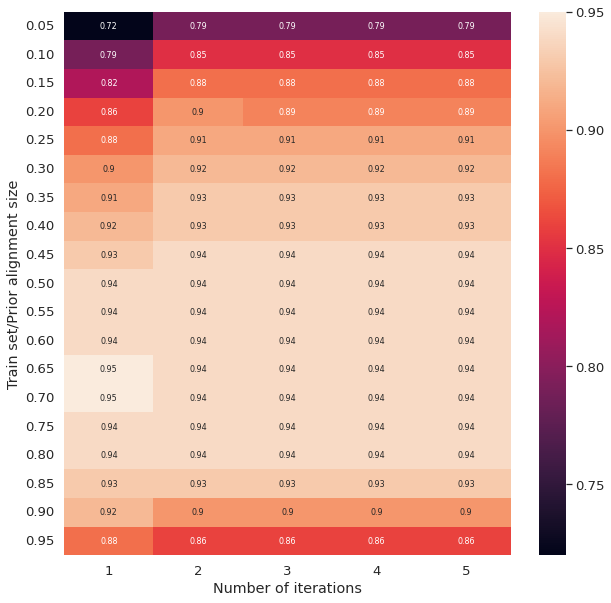

In [371]:
plt.figure(figsize=(10,10))

sns.set(font_scale=1.2)
ax=sns.heatmap(aucs, annot=True, annot_kws={"size": 8}, \
           yticklabels=alpha_range, xticklabels=arange(1,iter_count+1,1))
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Train set/Prior alignment size')
plt.savefig(f'./data/output/{mapping_file_name}.png')

In [370]:
aucs_df=pd.DataFrame(aucs, index=alpha_range, columns=arange(1,iter_count+1,1))

aucs_df.to_csv(f'./data/output/{mapping_file_name}.csv')

### Vertex alignment using k-fold cv

In [8]:
class VertexAlignment:
    
    '''
    Ground truth equivalent vertices in dictionary self.vertices_gt in format {v:v'}
    '''
    
     
    def __init__(self, g1, g2,mapping_file_dir):
        
        self.v1_e, self.v2_e, self.v_e = self.load_node_equivalences(g1.vertices, g2.vertices, mapping_file_dir)
        self.a1 = g1.adj_mat[self.v1_e,:][:,self.v1_e]
        self.a2 = g2.adj_mat[self.v2_e,:][:,self.v2_e]
        self.no_v1, self.no_v2, self.n = len(self.v1_e), len(self.v2_e), len(self.v_e)
        self.pairwise_degree_product = self.get_pairwise_degree_matrix(g1, g2)
        
    def kfold_cv(self, k):
        
        kf = KFold(n_splits=k)
        aucs=[]
        max_auc=0
        print(f'\nk-fold:{k}')
        for train, test in kf.split(self.v1_e):
            self.generate_base_alignment(train)
            self.compute_alignment(train)
            aucs.append(self.evaluate_model(test))
            print(f'auc: {aucs[-1]}')
        return aucs
            
            
    def generate_base_alignment(self, train):
        self.S0 = sparse.lil_matrix((self.no_v1, self.no_v2), dtype=np.float32)
        for i in train:
            self.S0[i,i]=1
            
            
    def compute_alignment(self,train):
        
        self.SV = sparse.lil_matrix((self.no_v1, self.no_v2), dtype=np.float32)
        self.SV_prev = self.S0.todense()
        min_threshold=0.0000000002
        while True:            
            self.SV=np.matmul(np.matmul(self.a1.todense(),self.SV_prev),self.a2.todense())
            self.SV/=self.pairwise_degree_product
            for i in train:
                self.SV[i,i]=1          
            delta_SV = (self.SV-self.SV_prev)
            if np.max(abs(delta_SV))<min_threshold:
                break
            self.SV_prev = self.SV.copy()
    
    
    def get_pairwise_alignment(self, v_i, v_j):
        return self.SV[g1.vertices.get(v_i)][g2.vertices.get(v_j)]
            
    
    def load_node_equivalences(self, v1, v2, mapping_file_dir):
        mapping = et.parse(mapping_file_dir)
        root = mapping.getroot()
        v1_e = []
        v2_e = []
        v_e={}
        for child in root:
            for grand in child.iter('{http://knowledgeweb.semanticweb.org/heterogeneity/alignment}map'):
                node1 = '<'+str(grand[0][0].attrib.values())[14:-3]+'>'
                node2 = '<'+str(grand[0][1].attrib.values())[14:-3]+'>'
                if v1.get(node1) and v2.get(node2):
                    v1_e.append(v1.get(node1))
                    v2_e.append(v2.get(node2))
                    v_e[v1.get(node1)]=v2.get(node2)

        return np.array(v1_e), np.array(v2_e), v_e
    
    def get_pairwise_degree_matrix(self,g1,g2):
        degree1,degree2=[],[]
        for i in range(self.no_v1):
            degree1.append(g1.degree.get(self.v1_e[i]))
            degree2.append(g2.degree.get(self.v2_e[i]))
        degree1=np.array(degree1).reshape(len(degree1),1)
        degree2=np.array(degree2).reshape(1,len(degree2))
        pairwise_degree=np.dot(degree1,degree2)
        return pairwise_degree

    
    def plot_heatmap(self):
        sv = pd.DataFrame(va.SV, index=list(g1.vertices.keys()), columns=list(g2.vertices.keys()))

        plt.figure(figsize=(10,10))
        sns.set(font_scale=1.2)
        sns.heatmap(sv, annot=True, annot_kws={"size": 8}, \
                   cmap=sns.diverging_palette(0, 200, n=500),\
                   yticklabels=list(g1.vertices.keys()), xticklabels=list(g2.vertices.keys()))
        

    def evaluate_model(self, test):
        sim_list = []
        vertex_gt = []
        for i in test:
            _v2 = self.v_e.get(self.v1_e[i])
            for j in test:
                sim_list.append(self.SV[i,j])
                if _v2==self.v2_e[j]:
                    vertex_gt.append(1)
                else:
                    vertex_gt.append(0)

        pred_y = np.array(sim_list)
        y = np.array(vertex_gt)
        fpr, tpr, threshold = roc_curve(y, pred_y)
        roc_auc = round(sklearn.metrics.auc(fpr, tpr),2)
        return roc_auc
            

In [32]:
filepath1 = '../../ontologyAlignment/data.Global/graphs/sw.nt'
filepath2 = '../../ontologyAlignment/data.Global/graphs/swg.nt'

mapping_file_dir = '../../ontologyAlignment/data.Global/mappings/sw_vs_swg.xml'
mapping_file_name = mapping_file_dir.split('/')[-1].split('.')[0]

g1 = Graph(filepath1)
g2 = Graph(filepath2)

va=VertexAlignment(g1,g2,mapping_file_dir)
aucs = va.kfold_cv(5)

aucs_df=pd.DataFrame(aucs, columns=['auc'])
aucs_df.to_csv(f'./data/output/{mapping_file_name}_5fold.csv')


Graph:  sw
Number of vertices:  773181
Number of edges:  8246033
Number of relations(edge labels):  715

Graph:  swg
Number of vertices:  57031
Number of edges:  254354
Number of relations(edge labels):  165

k-fold:5
auc: 0.58
auc: 0.61
auc: 0.62
auc: 0.62
auc: 0.63


In [29]:
aucs_df=pd.DataFrame(aucs, columns=['auc'])
aucs_df.to_csv(f'./data/output/{mapping_file_name}_5fold.csv')

In [294]:
# va=VertexAlignment(g1,g2)

# k_range = arange(2,10,1)
# aucs = []
# va=VertexAlignment(g1,g2)
# for k in (k_range):
#     avg_auc, max_auc = va.kfold_cv(k)
#     aucs.append([avg_auc, max_auc])
#     print(f'k: {k} avg_auc: {avg_auc} max_auc: {max_auc}\n')

# aucs

# aucs_df=pd.DataFrame(aucs, index=k_range, columns=['Avg auc','Max auc'])

# aucs_df.to_csv(f'./data/output/{mapping_file_name}_kfold.csv')

# # plt.figure(figsize=(10,10))

# # sns.set(font_scale=1.2)
# # ax=sns.heatmap(aucs, annot=True, annot_kws={"size": 8}, \
# #            yticklabels=k_range, xticklabels=['avg_auc','max_auc'])
# # ax.set_ylabel('k-fold')
# # # plt.savefig(f'./data/output/{mapping_file_name}.png')

In [342]:
aucs_csv = './data/output/sw_vs_swg_kfold.csv'
mapping_file_name = aucs_csv.split('/')[-1].split('.')[0]

aucs_df=pd.read_csv(aucs_csv)
aucs = aucs_df[['Avg auc', 'Max auc']]

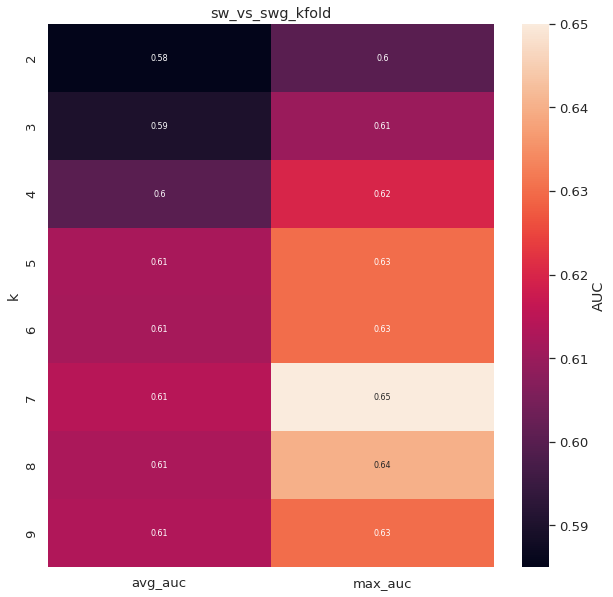

In [343]:
plt.figure(figsize=(10,10))

sns.set(font_scale=1.2)
ax=sns.heatmap(aucs, annot=True, annot_kws={"size": 8}, \
           yticklabels=k_range, xticklabels=['avg_auc','max_auc'], cbar_kws={'label':'AUC'})
ax.set_ylabel('k')
ax.set_title(mapping_file_name)
plt.savefig(f'./data/output/{mapping_file_name}.png')

#### Plotting standard error of mean and standard deviation

In [41]:
results=pd.read_csv('./data/output/result_5fold.csv')

In [59]:
files=list(results.columns)

In [60]:
stds=[]
avgs=[]
sems=[]
for file in files:
    aucs=results[file]
    std=np.std(aucs)
    avg=np.average(aucs)
    stds.append(std)
    avgs.append(avg)
    sems.append(std/np.sqrt(len(files)))

In [75]:
x=np.arange(0,5,1)
xticklabels=list(results.columns)

Text(0, 0.5, 'auc')

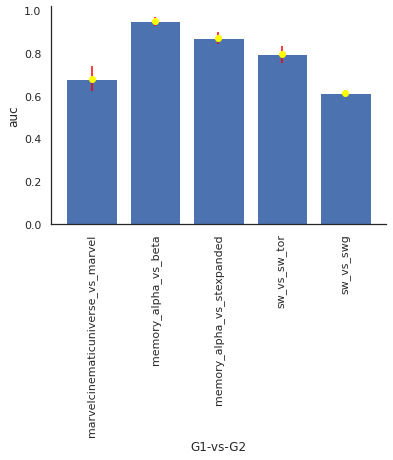

In [113]:

plt.bar(x,avgs)
plt.xticks(x,xticklabels,rotation=90)
plt.errorbar(x, avgs, yerr = stds, fmt='o', ecolor = 'red', color='yellow')
plt.xlabel('G1-vs-G2')
plt.ylabel('auc')

Text(0, 0.5, 'auc')

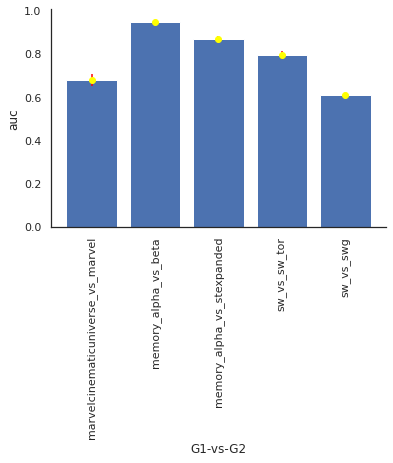

In [118]:

plt.bar(x,avgs)
plt.xticks(x,xticklabels,rotation=90)
plt.errorbar(x, avgs, yerr = sems, fmt='o', ecolor = 'red', color='yellow')
plt.xlabel('G1-vs-G2')
plt.ylabel('auc')

In [90]:
data={'x':xticklabels,'y':avgs}

[Text(0, 0, 'marvelcinematicuniverse_vs_marvel'),
 Text(1, 0, 'memory_alpha_vs_beta'),
 Text(2, 0, 'memory_alpha_vs_stexpanded'),
 Text(3, 0, 'sw_vs_sw_tor'),
 Text(4, 0, 'sw_vs_swg')]

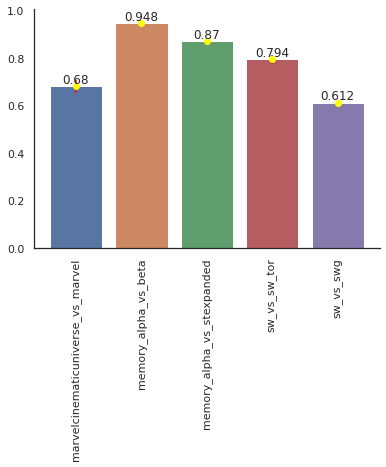

In [98]:

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
ax = sns.barplot(x="x", y="y", data=data)
ax.errorbar(x, avgs, yerr = sems,fmt='o',ecolor = 'red',color='yellow')
ax.bar_label(ax.containers[0])
ax.figure.tight_layout()
ax.set_xticklabels(data['x'],rotation = 90)

<ErrorbarContainer object of 3 artists>

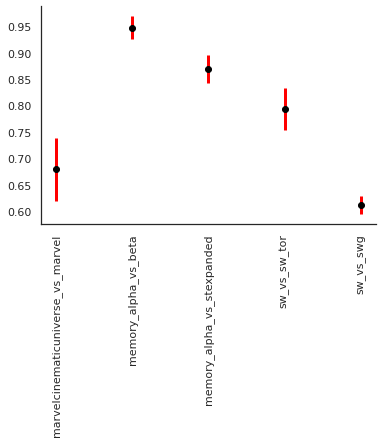

In [117]:
plt.xticks(x,xticklabels,rotation=90)
plt.errorbar(x, avgs, yerr=stds, fmt='o', color='black', ecolor='red', elinewidth=3, capsize=0)

<ErrorbarContainer object of 3 artists>

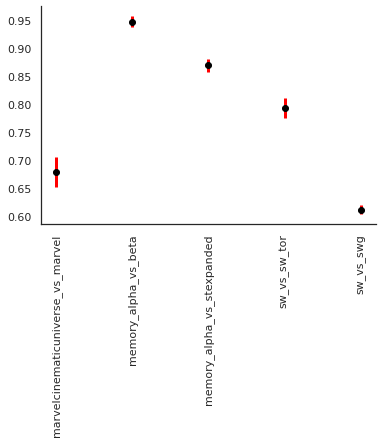

In [108]:
plt.xticks(x,xticklabels,rotation=90)
plt.errorbar(x, avgs, yerr=sems, fmt='o', color='black', ecolor='red', elinewidth=3, capsize=0)

Text(0, 0.5, 'auc')

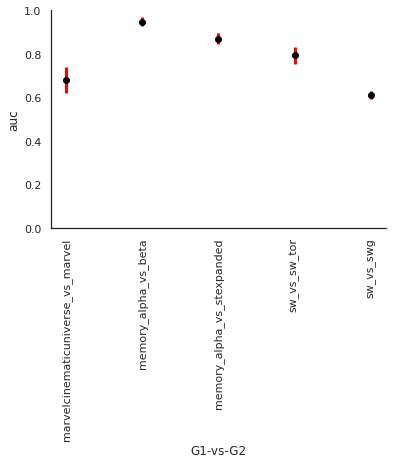

In [112]:
plt.xticks(x,xticklabels,rotation=90)
plt.errorbar(x, avgs, yerr=stds, fmt='o', color='black', ecolor='red', elinewidth=3, capsize=0)
plt.axis(ymin=0,ymax=1)
plt.xlabel('G1-vs-G2')
plt.ylabel('auc')